# ESP32-P4 Vehicle Classifier Controller

This notebook controls the P4-JIT Firmware to run the ESP-DL Vehicle Classifier dynamically.
It separates low-level JIT setup from high-level execution logic for better readability.

### 1. Imports and Setup

In [134]:
import sys
import os
import time
import struct
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Add P4-JIT Host path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..','..', '..', 'host')))
from p4jit import P4JIT, MALLOC_CAP_SPIRAM, MALLOC_CAP_DEFAULT, MALLOC_CAP_INTERNAL

### 2. Initialize P4-JIT Client

In [135]:
# Initialize JIT Client
p4 = P4JIT()

# Set Path to Firmware ELF (Required for linking)
FIRMWARE_ELF = os.path.abspath("../firmware/build/vehicle_classifier_jit.elf")
p4.builder.config['linker']['firmware_elf'] = FIRMWARE_ELF

print("P4-JIT Initialized.")

06:39:50 [p4jit.p4jit] INFO: Initializing P4JIT System...
06:39:50 [p4jit.runtime.jit_session] INFO: Auto-detecting JIT device...
06:39:50 [p4jit.runtime.device_manager] INFO: Connecting to COM3 at 115200 baud...
06:39:50 [p4jit.runtime.device_manager] WARNING: Port COM6 is already open by another instance. Forcing disconnect...
06:39:50 [p4jit.runtime.device_manager] INFO: Disconnecting COM6...
06:39:50 [p4jit.runtime.device_manager] INFO: Disconnected.
06:39:50 [p4jit.runtime.device_manager] INFO: Connecting to COM6 at 115200 baud...
06:39:50 [p4jit.runtime.device_manager] INFO: Connected.
06:39:50 [p4jit.runtime.jit_session] INFO: Found JIT Device at COM6
06:39:50 [p4jit.p4jit] INFO: P4JIT Initialized.
P4-JIT Initialized.


### 3. Parameters & Constants

In [136]:
# Image Dimensions (Updated for new 256x256 Model)
IMAGE_W = 256
IMAGE_H = 256

# Normalization Constants (MobileNet)
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Model Path
MODEL_PATH = "models/vehicle_classifier.espdl"

### 4. C Wrapper Definitions

In [137]:
C_WRAPPERS = r"""
#include <stdint.h>
#include <stdio.h>

// Firmware API Declarations
extern void app_model_init_from_ram(void *ptr);
extern void app_preprocess_from_buffer(uint8_t *raw, int w, int h, float *mean, float *std);
extern void app_model_run(void);
extern float app_get_score(int idx);

// Variables to peek at from JIT
extern int G_INPUT_EXPONENT;
extern int G_OUTPUT_EXPONENT;
extern int8_t *G_INPUT_TENSOR;

// JIT Wrappers
void jit_init(int ptr) {
    printf("JIT DEBUG: Calling Init with ptr: 0x%x\n", ptr);
    app_model_init_from_ram((void*)ptr);
    printf("JIT DEBUG: Initialized. Input Exponent: %d\n", G_INPUT_EXPONENT);
}

void jit_preprocess(int raw_addr, int w, int h, float *mean, float *std) {
    uint8_t* raw = (uint8_t*)raw_addr;
    printf("JIT DEBUG: Preprocessing %dx%d image at 0x%x\n", w, h, raw_addr);
    
    app_preprocess_from_buffer(raw, w, h, mean, std);
    
    if (G_INPUT_TENSOR) {
        printf("JIT DEBUG: First 3 Quantized Tensor Vals: %d %d %d\n", 
               G_INPUT_TENSOR[0], G_INPUT_TENSOR[1], G_INPUT_TENSOR[2]);
    } else {
        printf("JIT DEBUG: ERROR - G_INPUT_TENSOR is NULL!\n");
    }
}

void jit_run(void) {
    app_model_run();
}

float jit_get_score(int idx) {
    return app_get_score(idx);
}
"""

### 5. Compile and Load Wrappers

In [138]:
if not os.path.exists("generated"): os.makedirs("generated")
with open("generated/wrappers.c", "w") as f: f.write(C_WRAPPERS)

print("Compiling JIT Wrappers...")
caps = P4JIT.MALLOC_CAP_INTERNAL | P4JIT.MALLOC_CAP_EXEC

func_init = p4.load("generated/wrappers.c", "jit_init", code_caps=caps)
func_preprocess = p4.load("generated/wrappers.c", "jit_preprocess", code_caps=caps)
func_run = p4.load("generated/wrappers.c", "jit_run", code_caps=caps)
func_get_score = p4.load("generated/wrappers.c", "jit_get_score", code_caps=caps)

print("Wrappers Loaded.")

Compiling JIT Wrappers...
06:39:50 [p4jit.p4jit] INFO: Loading 'jit_init' from 'wrappers.c'...
06:39:50 [p4jit.toolchain.wrapper_builder] INFO: Generating wrapper for 'jit_init'
06:39:50 [p4jit.toolchain.wrapper_builder] INFO: Building wrapper binary...
06:39:50 [p4jit.toolchain.builder] INFO: Discovered 2 source file(s) in c:\Users\orani\bilel\git_projects\robert_manzke\project1\trys\costume_p4code_binary\P4-JIT\projects\esp_dl\esp32-p4-vehicle-classifier\notebooks\generated
06:39:50 [p4jit.toolchain.builder] INFO: Build validation passed
06:39:50 [p4jit.toolchain.wrapper_builder] INFO: Wrapper build complete. Metadata saved to c:\Users\orani\bilel\git_projects\robert_manzke\project1\trys\costume_p4code_binary\P4-JIT\projects\esp_dl\esp32-p4-vehicle-classifier\notebooks\build\signature.json
06:39:51 [p4jit.p4jit] INFO:   Code Allocated: 0x4FF3FA70 (224 bytes)
06:39:51 [p4jit.p4jit] INFO:   Args Allocated: 0x49080AE0 (128 bytes)
06:39:51 [p4jit.toolchain.wrapper_builder] INFO: Generati

### 6. Python Helper Functions

In [139]:
def upload_model_to_device(path):
    """Reads .espdl file and uploads to PSRAM."""
    print(f"Reading {path}...")
    with open(path, "rb") as f: model_data = f.read()
    
    size = len(model_data)
    # Allocate
    addr = p4.session.device.allocate(size, MALLOC_CAP_SPIRAM, 16)
    print(f"Allocated {size/1024:.1f} KB at {hex(addr)}")
    
    # Write
    p4.session.device.write_memory(addr, model_data)
    
    # Init (Pass as np.int32 to avoid warnings)
    func_init(np.int32(addr))
    print("Model Initialized on Device.")
    return addr

def run_classification(image_path, rgb_buffer_addr):
    """Run full classification pipeline on a single image."""
    # 1. Load Image
    img = Image.open(image_path).resize((IMAGE_W, IMAGE_H)).convert('RGB')

    raw_arr = np.array(img, dtype=np.uint8).flatten()
    
    # 2. Visulization
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Testing: {os.path.basename(image_path)}")
    plt.show()
    
    # 3. Upload Image to Scratch Buffer
    p4.session.device.write_memory(rgb_buffer_addr, raw_arr.tobytes())
    
    # 4. Preprocess (Pass int32 for manual pointers)
    func_preprocess(np.int32(rgb_buffer_addr), 
                    np.int32(IMAGE_W), 
                    np.int32(IMAGE_H), 
                    MEAN, 
                    STD)
    
    # 5. Run Inference
    func_run()
    
    # 6. Get Scores
    score0 = func_get_score(np.int32(0)) # Not Vehicle
    score1 = func_get_score(np.int32(1)) # Vehicle
    
    print(f"Scores -> Not Vehicle: {score0:.4f}, Vehicle: {score1:.4f}")
    
    if score1 > score0:
        print("\033[92mRESULT: VEHICLE DETECTED\033[0m")
    else:
        print("\033[91mRESULT: NO VEHICLE\033[0m")
    print("-" * 30)

--- 
## Execution
Run the following cells to execute the pipeline.

### Step 1: Upload Model

In [140]:
upload_model_to_device(MODEL_PATH)

Reading models/vehicle_classifier.espdl...
Allocated 2598.6 KB at 0x49080d60
Model Initialized on Device.


1225264480

### Step 2: Allocate Image Buffer

In [141]:
# Allocate once, reuse for all images
# Buffer size now 256*256*3 = 196,608 bytes
RGB_SCRATCH = p4.session.device.allocate(IMAGE_W * IMAGE_H * 3, MALLOC_CAP_SPIRAM, 16)
print(f"Image Buffer Allocated at {hex(RGB_SCRATCH)}")

Image Buffer Allocated at 0x4955eb20


### Test Case A: Vehicle 0

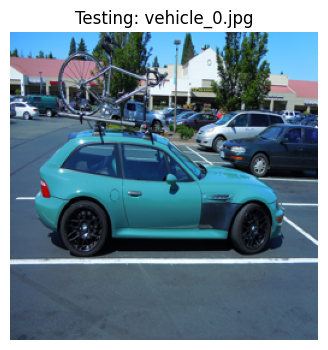

Scores -> Not Vehicle: -5.0000, Vehicle: 5.7500
RESULT: VEHICLE DETECTED
------------------------------


In [142]:
run_classification("images/vehicle_0.jpg", RGB_SCRATCH)

### Test Case B: Vehicle 1

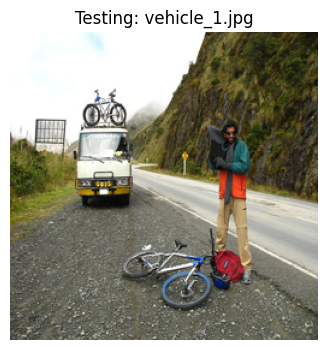

Scores -> Not Vehicle: -3.9375, Vehicle: 4.5000
RESULT: VEHICLE DETECTED
------------------------------


In [143]:
run_classification("images/vehicle_1.jpg", RGB_SCRATCH)

### Test Case C: Not Vehicle 0

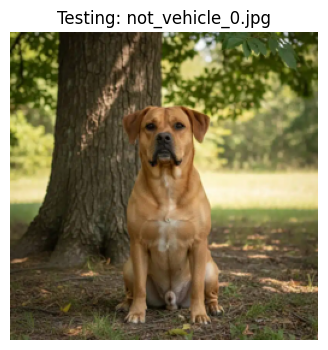

Scores -> Not Vehicle: 2.3125, Vehicle: -2.2500
RESULT: NO VEHICLE
------------------------------


In [144]:
run_classification("images/not_vehicle_0.jpg", RGB_SCRATCH)

### Test Case D: Not Vehicle 1

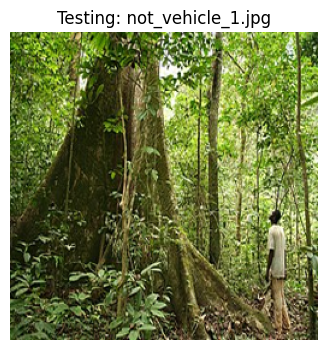

Scores -> Not Vehicle: 2.5625, Vehicle: -2.5000
RESULT: NO VEHICLE
------------------------------


In [145]:
run_classification("images/not_vehicle_1.jpg", RGB_SCRATCH)

## other tests

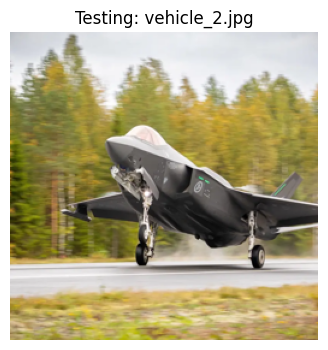

Scores -> Not Vehicle: -2.0000, Vehicle: 2.3125
RESULT: VEHICLE DETECTED
------------------------------


In [146]:
run_classification("images/vehicle_2.jpg", RGB_SCRATCH)

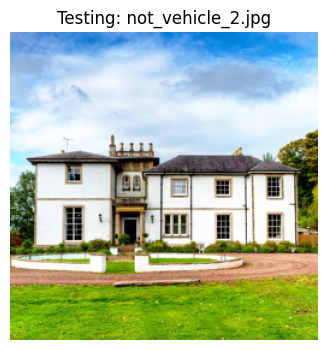

Scores -> Not Vehicle: 0.8750, Vehicle: -0.5625
RESULT: NO VEHICLE
------------------------------


In [147]:
run_classification("images/not_vehicle_2.jpg", RGB_SCRATCH)